In [1]:
import pandas as pd
from sklearn import svm
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#from sklearn.neighbors.nca import NeighborhoodComponentsAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from sklearn import model_selection
from sklearn.model_selection import KFold
import xgboost as xgb
import random
# from imblearn.over_sampling import SMOTE
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from time import time
from sklearn import manifold
from matplotlib.ticker import NullFormatter
import operator, itertools 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Harsh: Use Python[pytorch] kernel <others, please ignore this line>

### Considering on dummy data 

In [2]:
# Input data : 
# X = num_edges x num_methods, 
# y = predictions (I - 0/1 values; II - 0/1/2/3 hop connections)

E = 10000 # number of edges
M = 6 # number of methods
X = np.random.rand(E, M)
y = np.random.choice([0, 1], size=E, p=[.9, .1]) # percentage labels

## Visualizing the data
Sometimes it can be helpful, so why not!

In [3]:
def visual2D(X, color):
    Axes3D
    n_points = len(color)
    S = 30 # point size for figures

    n_neighbors = 10
    n_components = 2

    # fig = plt.figure(figsize=(15, 8))
    fig = plt.figure(figsize=(20, 8))
    plt.suptitle("2D projection with %i points, %i neighbors"
                 % (n_points, n_neighbors), fontsize=14)

    methods = ['standard', 'ltsa', 'hessian', 'modified']
    labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

    for i, method in enumerate(methods):
        t0 = time()
        Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                            eigen_solver='dense',
                                            method=method).fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (methods[i], t1 - t0))

        ax = fig.add_subplot(252 + i)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
        plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    t0 = time()
    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    t1 = time()
    print("Isomap: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(257)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("Isomap (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    t1 = time()
    print("MDS: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(258)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("MDS (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    se = manifold.SpectralEmbedding(n_components=n_components,
                                    n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    t1 = time()
    print("SpectralEmbedding: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(259)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=5)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(2, 5, 10)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("t-SNE (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()

standard: 0.056 sec
ltsa: 0.12 sec
hessian: 0.15 sec
modified: 0.11 sec
Isomap: 0.3 sec
MDS: 0.5 sec
SpectralEmbedding: 0.14 sec
t-SNE: 2.5 sec


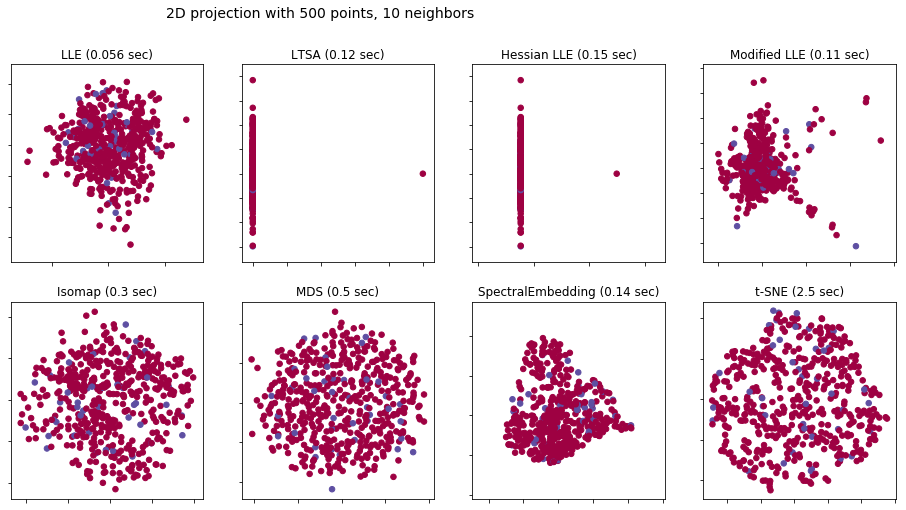

In [5]:
# randomly choose points for visualization
vizPts = 500
visual2D(X[:vizPts, :], y[:vizPts])

## Binary Classification using traditional ML techniques - XGBoost

In [6]:
clf_VERSION = 'v1'
K = 5 # 5 fold cv

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.array(cm)
        cm = np.around(cm/cm.sum(axis=1)[:, None]*100).astype('int')
        print("Percentage confusion matrix")
        print(cm.sum(axis=1))
    else:
        print('Confusion matrix, without normalization')

#    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def show_confusion_matrix(y, pred_array):
    y = np.array(y).astype(int)
    y_pred = np.array(pred_array)

    cnf_matrix = confusion_matrix(y, y_pred)
    np.set_printoptions(precision=2)
    sorted_cnf_matrix = cnf_matrix
    class_names = ['yes', 'no'] #[0, 1]

    plot_confusion_matrix(sorted_cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
    plt.show()
    return


def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_auc_plot(y, scores):
    y = np.array(y).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
#    print(fpr, tpr, thresholds)
    # Getting accuracy, sensitivity and accuracy plot for varying thresholds. 
    accuracy_array = []
    sensitivity_array = [x*100 for x in tpr]
    specificity_array = [(1-x)*100 for x in fpr]#(1-fpr)*100
    for i, th in enumerate(thresholds):
        pred_array = []
        for s in scores:
            if s>th:
                pred_array.append(1)
            else:
                pred_array.append(0)
        accuracy_array.append(accuracy_score(y, pred_array))
#         print('For threshold : ', th, '->', ' Accuracy ', accuracy_array[i], 
#               ' Sensitivity ', sensitivity_array[i], 'specificity ', specificity_array[i])
#         show_confusion_matrix(y, pred_array)
#     print('accuracy_array', accuracy_array)
#     print('sensitivity_array', sensitivity_array)
#     print('specificity_array', specificity_array)
#     print('thresholds_array', thresholds)
    
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    for i in range(len(fpr)):
        if fpr[i] > 0.01:
            break
    return roc_auc, tpr[i], fpr[i]

def get_auc(y, scores):
    y = np.array(y).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)

    for i in range(len(fpr)):
        if fpr[i] > 0.01:
            break
    return roc_auc#, tpr[i], fpr[i]


def trainXGB(Xtrain, ytrain, Xtest, ytest):
    dtrain = xgb.DMatrix(Xtrain,label=ytrain)
    dtest = xgb.DMatrix(Xtest,label=ytest)
    print('Setting XGB params')
    evallist  = [(dtest,'test'), (dtrain,'train')]
    
    param = {}
    # use softmax multi-class classification
#    param['objective'] = 'multi:softprob'#'multi:softmax'
    param['objective'] = 'binary:logistic' #'multi:softprob'
    # scale weight of positive examples
    param['eta'] = 0.05
    param['max_depth'] = 5
    param['gamma'] = 0
    param['silent'] = 1
    param['nthread'] = 6
    param['subsample'] = 0.5#0.7 # number of examples for 1 tree (subsampled from total)
    param['colsample_bytree'] = 0.5#0.7 # ratio of columns for training 1 tree
#    param['num_class'] = NUM_CLASS
    param['eval_metric'] = 'auc'#'mlogloss' #auc

    # CLASS Imbalance handling!
    param['scale_pos_weight'] = 10#190/10 # sum(negative cases) / sum(positive cases)
    
#    param['booster'] = 'dart' #'gblinear' # default is tree booster
#    param['lambda'] = 1
#    param['alpha'] = 1

    num_round = 220#60
    print('training the XGB classifier')
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=100, verbose_eval=False)
    #print('training completed, printing the relative importance: \
    #      (feature id: importance value)')
    importance = bst.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    #print(importance)
    
    # we will print from df1 dataframe, getting the corresponding feature names. 
    df1 = pd.DataFrame(importance, columns=['feature', 'fscore'])
    # Normalizing the feature scores
    df1['fscore'] = df1['fscore'] / df1['fscore'].sum()
    
    #print(df1)
    # adding a column of feature name
    column_names = df.columns[:-1]
    df1['feature_names'] = pd.Series([df.columns[int(f[0].replace("f", ""))] for f in importance])
    
    df1.plot()
    df1.plot(kind='barh', x='feature_names', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.gcf().savefig('feature_importance_xgb.png')
    plt.show()
#    print 'Saving the models'
#    bst.save_model(name+'_xgb_v'+clf_VERSION+'.model')
#    bst.dump_model(name+'_xgb_v'+clf_VERSION+'_dump.raw.txt')
#    bst.dump_model(name+'_xgb_v'+clf_VERSION+'_dump.raw.txt',name+'_xgb_v'+clf_VERSION+'_featmap.txt')
    return bst


def classifier_train(X, y, runXGB, Xtest, ytest, pca_comp=0): # pca = 0 means no PCA applied
    print('Normalising the input data...')
    scaler = StandardScaler()
    scaler.fit(X)  
    scaledX = scaler.transform(X)
    if pca_comp != 0:
        pca = PCA(n_components = pca_comp)
        pca.fit(scaledX)
        pca_scaledX = pca.transform(scaledX)
    else:
        pca_scaledX = scaledX
        pca =0

    if runXGB == 1:
        print('Running the XGB classifier')
        clf = trainXGB(pca_scaledX, y, scaler.transform(Xtest), ytest)
        index = 1
    return scaler, pca, clf, index


def classifier_test(X, y, clf, index, scaler, pca):
    scaledX = scaler.transform(X)
    pca_scaledX = scaledX
    if pca != 0:
        pca_scaledX = pca.transform(scaledX)
    if index==1:# XGB
        pca_scaledXG = xgb.DMatrix(pca_scaledX, label=y)
        pred_array = clf.predict(pca_scaledXG, ntree_limit=clf.best_iteration)
        #.reshape(y.shape[0], NUM_CLASS)#, ntree_limit=clf.best_iteration)
        scores = pred_array

#    auc = get_auc(y, scores)

    auc = get_auc_plot(y, scores)
    # Compute confusion matrix
#    show_confusion_matrix(y, pred_array)
    return pred_array, auc# error


def pandas_classifier(df, runXGB, K=5):
    print('Performing ' + str(K) + '-fold cross validation')
    auc_fold = []
    for k in range(K):# performing K fold validation
        #if k == 0: # running only for k'th fold
            print('Fold_num = ' + str(k))
            training_rows = [i for i in range(len(df)) if i%K!=k]
            datatrain = df.loc[training_rows] # training
            testing_rows = [i for i in range(len(df)) if i%K==k]
            datatest = df.loc[testing_rows] # taking every k'th example for test
            Xtrain = datatrain.iloc[:, 0:-1]
            ytrain = datatrain.iloc[:, -1]
            Xtest = datatest.iloc[:, 0:-1]
            ytest = datatest.iloc[:, -1]
            print('--------------------------------------------------------------')
            print('Calling the classifier to train')
            scaler, pca, clf, index = classifier_train(Xtrain, ytrain, runXGB, Xtest, ytest)
            print('Analysing the test predictions for fold num ', k)
            pred_array, auc = classifier_test(Xtest, ytest, clf, index, scaler, 0)
            auc_fold.append(auc[0])
            print('test auc = '+str(auc[0]) )
            print('------------------------------------------------------------')
    if K != 0:
        print('************************************************************************')
        print(auc_fold)#, sum(np.array(auc_fold))/int(K))
        print('Average '+str(K)+' fold CV result= ', str(sum(np.array(auc_fold))/int(K)))
        print('************************************************************************')
    print('Training the classifier on complete train dataset to get IMP features')
    scaler, pca, clf, index = classifier_train(df.iloc[:, 0:-1], df.iloc[:, -1],
                                               runXGB, df.iloc[:, 0:-1], df.iloc[:, -1])
    return

Performing 5-fold cross validation
Fold_num = 0
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


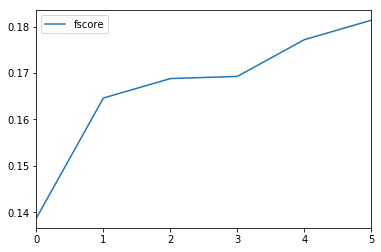

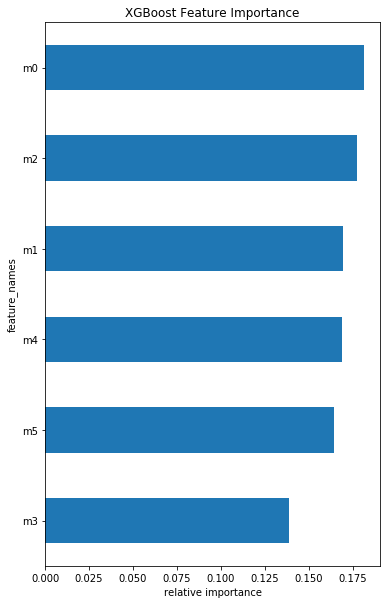

Analysing the test predictions for fold num  0


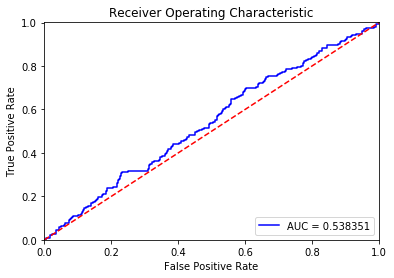

test auc = 0.5383512649025879
------------------------------------------------------------
Fold_num = 1
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


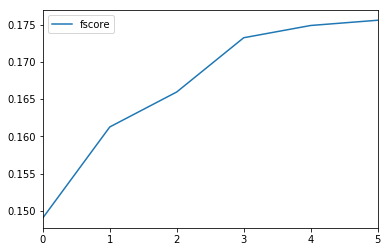

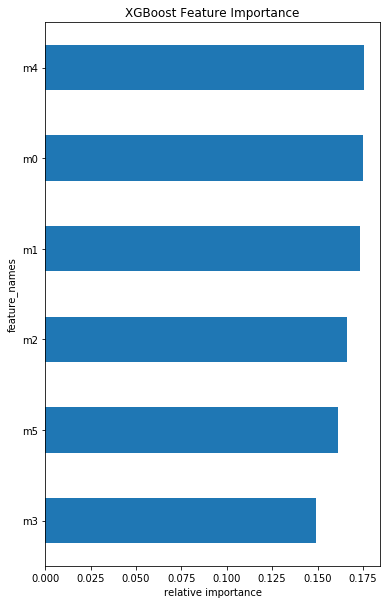

Analysing the test predictions for fold num  1


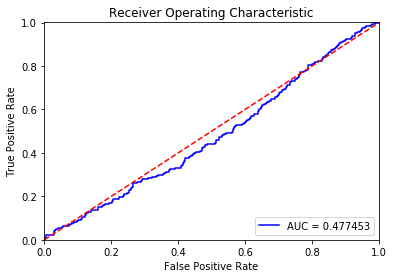

test auc = 0.4774532108516484
------------------------------------------------------------
Fold_num = 2
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


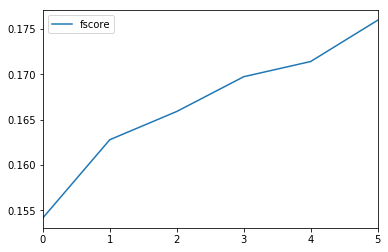

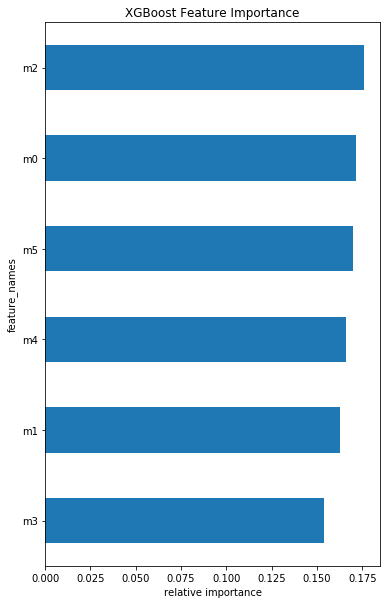

Analysing the test predictions for fold num  2


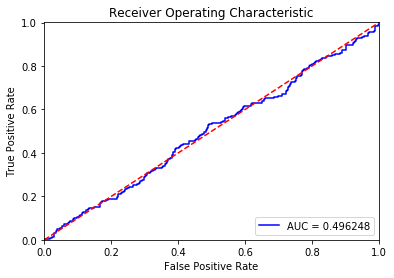

test auc = 0.49624785276729205
------------------------------------------------------------
Fold_num = 3
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


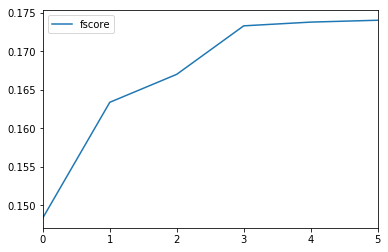

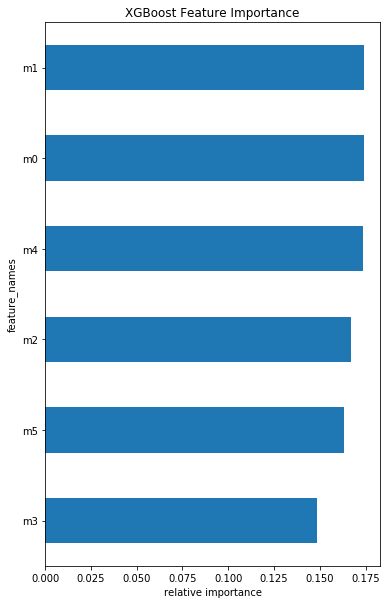

Analysing the test predictions for fold num  3


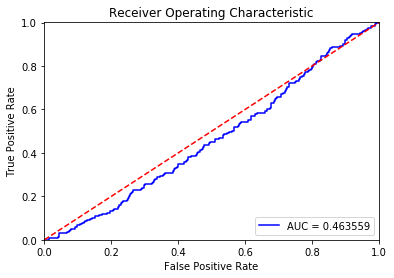

test auc = 0.46355866567022214
------------------------------------------------------------
Fold_num = 4
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


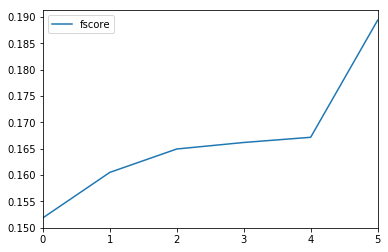

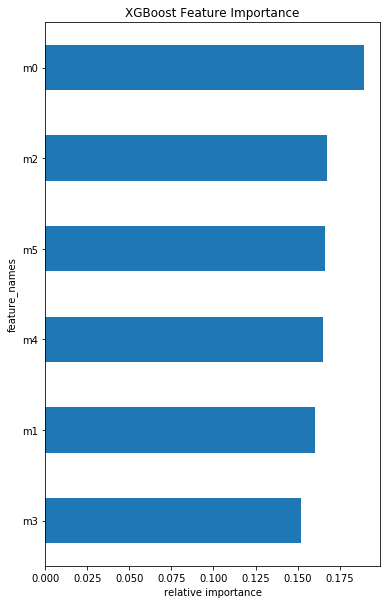

Analysing the test predictions for fold num  4


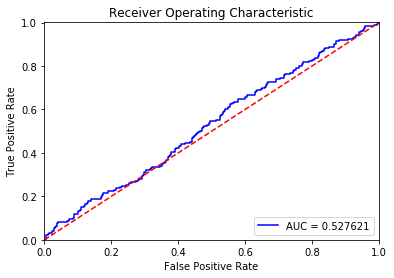

test auc = 0.5276214498366346
------------------------------------------------------------
************************************************************************
[0.5383512649025879, 0.4774532108516484, 0.49624785276729205, 0.46355866567022214, 0.5276214498366346]
Average 5 fold CV result=  0.500646488805677
************************************************************************
Training the classifier on complete train dataset to get IMP features
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


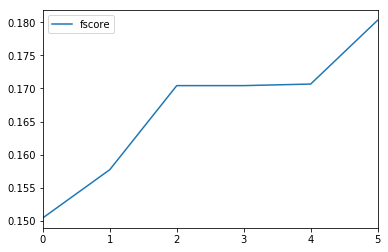

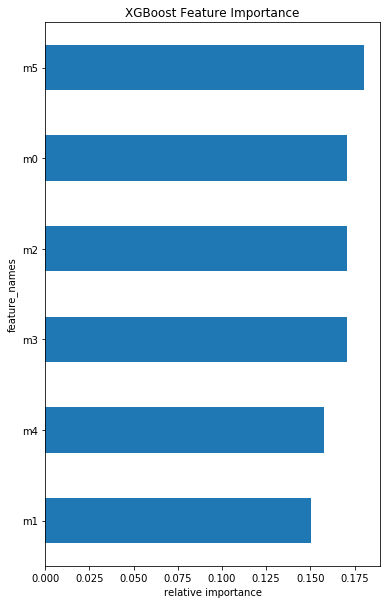

In [10]:
# Convert data to pandas before passing 
np.random.seed(15)
random.seed(15)
df_X = pd.DataFrame(X, columns=['m'+str(i) for i in range(6)])
df_y = pd.DataFrame(pd.Series(y, name='label'))
df = pd.concat([df_X, df_y], axis=1)
#print(df_classifier, df)
#print(df.columns)

pandas_classifier(df, 1)